## Model-predictive control for mobile robot navigation

Wouter Kouw, last update: 06-06-2024

### Robot dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ \dot{x}_{1,k} \\ \dot{x}_{2,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ \dot{x}_{1,k-1} \\ \dot{x}_{2,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{1,k} \\ u_{2,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_1 & 0 & \frac{\Delta t^2}{2} \rho_1 & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_2 & 0 & \frac{\Delta t^2}{2} \rho_2 \\
                      \frac{\Delta t^2}{2} \rho_1 & 0 & \Delta t \rho_1 & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_2 & 0 & \Delta t \rho_2 \end{bmatrix} \, .$$

### Observations: polar coordinates from beacon

In the middle of a training area, there is a beacon that reports range and angle to the robot. This will allow it to infer its position in the field through a polar-to-cartesian transformation:

$$\begin{align}
y_{1,k} &= g_1(z_k) = \sqrt{x_{1,k}^2 + x_{2,k}^2} \\
y_{2,k} &= g_2(z_k) = \mathrm{atan}(x_{1,k}, x_{2,k}) \, ,
\end{align}$$

where $\mathrm{atan}$ refers to the arctangent. We denote this as:

$$y_k = g(z_k) + r_k$$

where $r_k$ is measurement noise. 

### Model-predictive controller

To control the robot, we unroll the dynamical system T steps into the future, i.e., from $t = (k+1, \dots, k+T). We then form an objective function based on how close the predicted states are to the desired state

$$J(u_t) = \sum_{t=1}^T \big((Az_{t-1} + Bu_t) - z_{*} \big)^{\top} F \big((Az_{t-1} + Bu_t) - z_{*}\big) + \eta u_t^2$$

starting from the current state estimate $z_0 = \mathbb{E}[z_k]$.

## Experiment

In [233]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using Revise
using Colors
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using StatsPlots
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)
includet("../Robots.jl"); using. Robots
includet("../ModelPredictiveControllers.jl"); using. ModelPredictiveControllers
includet("../util.jl");

  Activating project at `c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-planning\IWAI2024-ambiguity\demonstrations`


In [289]:
# Time
Δt = 0.5
len_trial = 10
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 5;
     
# Nonlinear observation
g(x::AbstractVector) = [sqrt(x[1]^2 + x[2]^2), atan(x[2],x[1])]

# Setpoint (desired observation)
z_star = [0.0, 1., 0.0, 0.0]

# Parameters
σ = 1e-2
ρ = [1e-2, 1e-2]
η = 0.0

# Limits of controller
u_lims = (-1.0, 1.0)
opts = Optim.Options(time_limit=20)

# Cost matrix
F = [1. 0. 0.  0.;
     0. 1. 0.  0.;
     0. 0. 0.  0.;
     0. 0. 0.  0.]

# Initial state
z_0 = [0.0, -1., 0., 0.]

# Initial belief
m_0 = z_0
S_0 = 0.5diagm(ones(4));

fbot = FieldBot(g, ρ, σ=σ, Δt=Δt, control_lims=u_lims)
mpcontrol = MPController(z_star, g, ρ, σ=σ; η=η, Δt=Δt, time_horizon=len_horizon, cost_matrix=F)

MPController(4, 2, 2, 0.5, g, [1.0 0.0 0.5 0.0; 0.0 1.0 0.0 0.5; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.0 0.0; 0.5 0.0; 0.0 0.5], [0.00041666666666666664 0.0 0.00125 0.0; 0.0 0.00041666666666666664 0.0 0.00125; 0.00125 0.0 0.005 0.0; 0.0 0.00125 0.0 0.005], [0.0001 0.0; 0.0 0.0001], 0.0, [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [0.0, 1.0, 0.0, 0.0], 5)

In [290]:
# Preallocate
z_est = (zeros(4,len_trial), zeros(4,4,len_trial))
z_pln = (zeros(len_trial, 4,len_horizon), zeros(len_trial, 4,4,len_horizon))
y_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
z_sim = zeros(4,len_trial)
y_sim = zeros(2,len_trial)
u_sim = zeros(2,len_trial)
F_MPC = zeros(len_trial)
J_MPC = zeros(len_trial)

# Initial state
z_sim[:,1] = z_0
z_est[1][:,1] = m_0
z_est[2][:,:,1] = S_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

# Initialize policy
policy = zeros(len_trial, 2, len_horizon)

@showprogress for k in 1:len_trial
    
    if k > 1
    
        "Interact with environment"

        # Update system with selected control
        y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])
                
        "State estimation"
        
        m_k_pred, S_k_pred = predict(mpcontrol, m_kmin1, S_kmin1, u_sim[:,k-1])
        m_k,S_k = correct(mpcontrol, y_sim[:,k], m_k_pred, S_k_pred, approx="ET2")
        
        # Compute model evidence
        F_MPC[k] = evidence(mpcontrol, y_sim[:,k], m_k, S_k, approx="ET2")
        J_MPC[k] = -logpdf(MvNormal(goal[1], goal[2]), y_sim[:,k])
        
        # Store state estimates
        z_est[1][:,k] = m_k
        z_est[2][:,:,k] = S_k

    else
        m_k = m_0
        S_k = S_0
    end
    
    "Planning"
    
    # Single-argument objective
    J(u::AbstractVector) = objective(mpcontrol, u, (m_k,S_k))
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(J, u_lims[1], u_lims[2], zeros(2len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy[k,:,:] = reshape(Optim.minimizer(results), (2,len_horizon))
    
    # Planning
    planned_states, planned_obs = planned_trajectory(mpcontrol, policy[k,:,:], (m_k,S_k))
    z_pln[1][k,:,:]   = planned_states[1]
    z_pln[2][k,:,:,:] = planned_states[2] 
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
    
    # Execute first planned action only
    u_sim[:,k] = policy[k,:,1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


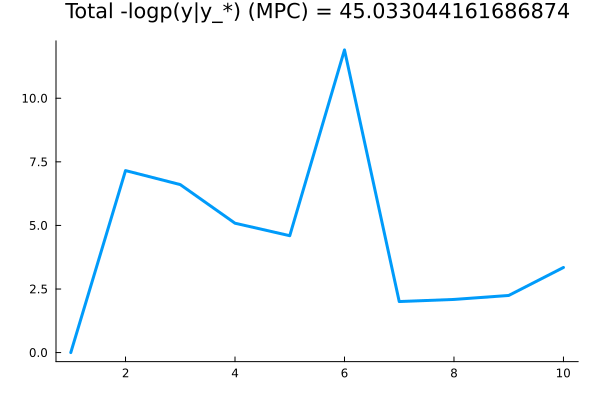

In [291]:
tJ_MPC = sum(J_MPC)
plot(J_MPC, title="Total -logp(y|y_*) (MPC) = $tJ_MPC")

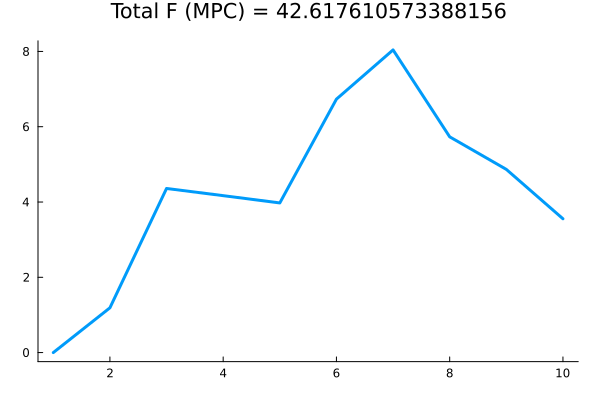

In [292]:
tF_MPC = sum(F_MPC)
plot(F_MPC, title="Total F (MPC) = $tF_MPC")

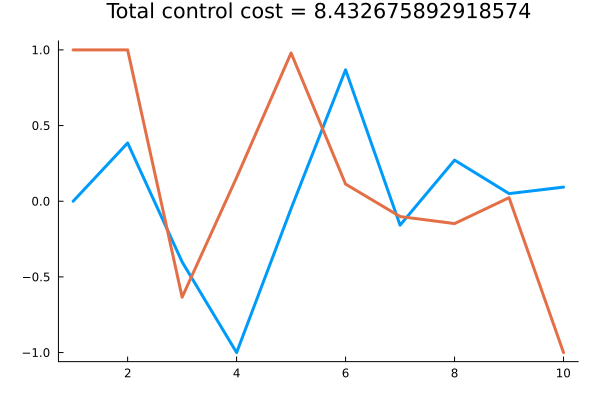

In [293]:
tU = sum(abs.(u_sim[:]))
plot(u_sim', title="Total control cost = $tU")

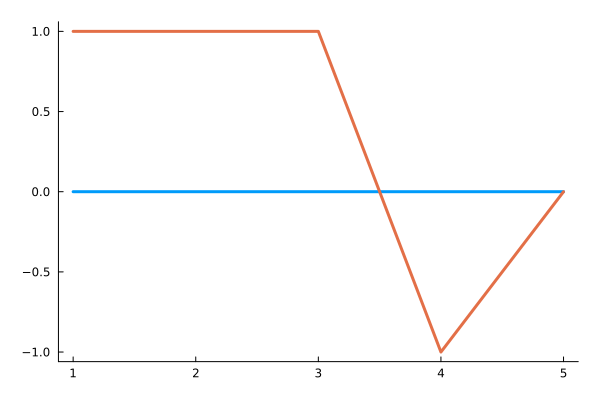

In [294]:
plot(policy[1,:,:]')

┌ Info: Saved animation to c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-planning\IWAI2024-ambiguity\demonstrations\animations\cart2polar-experiment-MPC-path.gif
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\animation.jl:156


Plots.AnimatedGif("c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\animations\\cart2polar-experiment-MPC-path.gif")
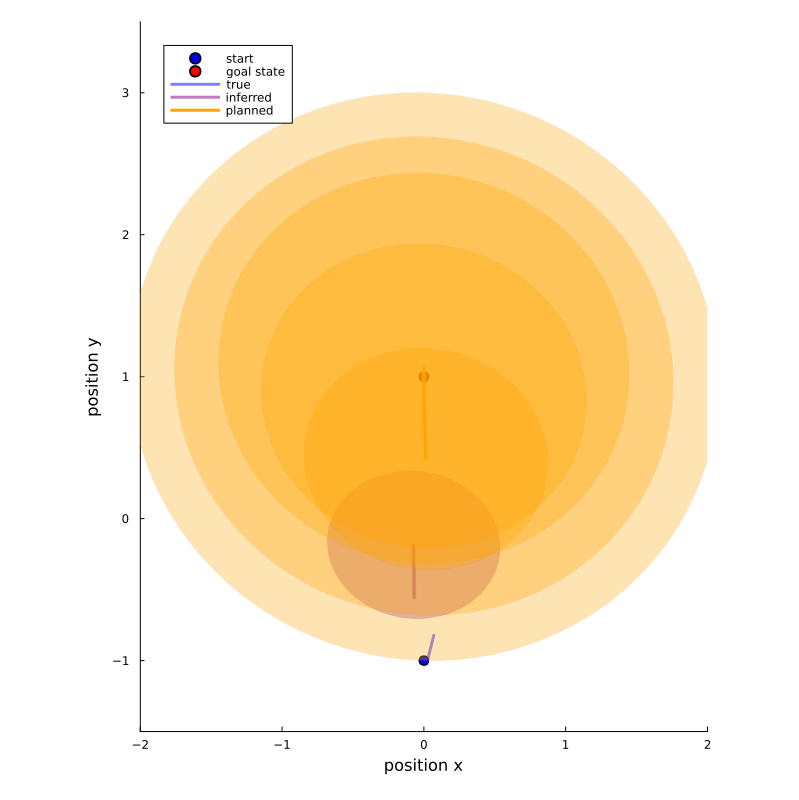

In [295]:
xl = [-2., 2.]
yl = [-1.5, 3.5]

anim = @animate for k in 3:len_trial
    p301 = plot(size=(800,800), legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
    scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
    scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
    plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", label="true", alpha=0.5)
    plot!(z_est[1][1,2:k], z_est[1][2,2:k], c="purple", label="inferred", alpha=0.5)
    covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=0, fillalpha=0.3)
    
    plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], c="orange", label="planned")
    for j in 1:len_horizon
        covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=0, fillalpha=0.3)
    end
end
gif(anim, "animations/cart2polar-experiment-MPC-path.gif", fps=3) 

┌ Warning: Skipped marker arg ..
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\args.jl:1148
┌ Warning: Skipped marker arg ..
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\args.jl:1148


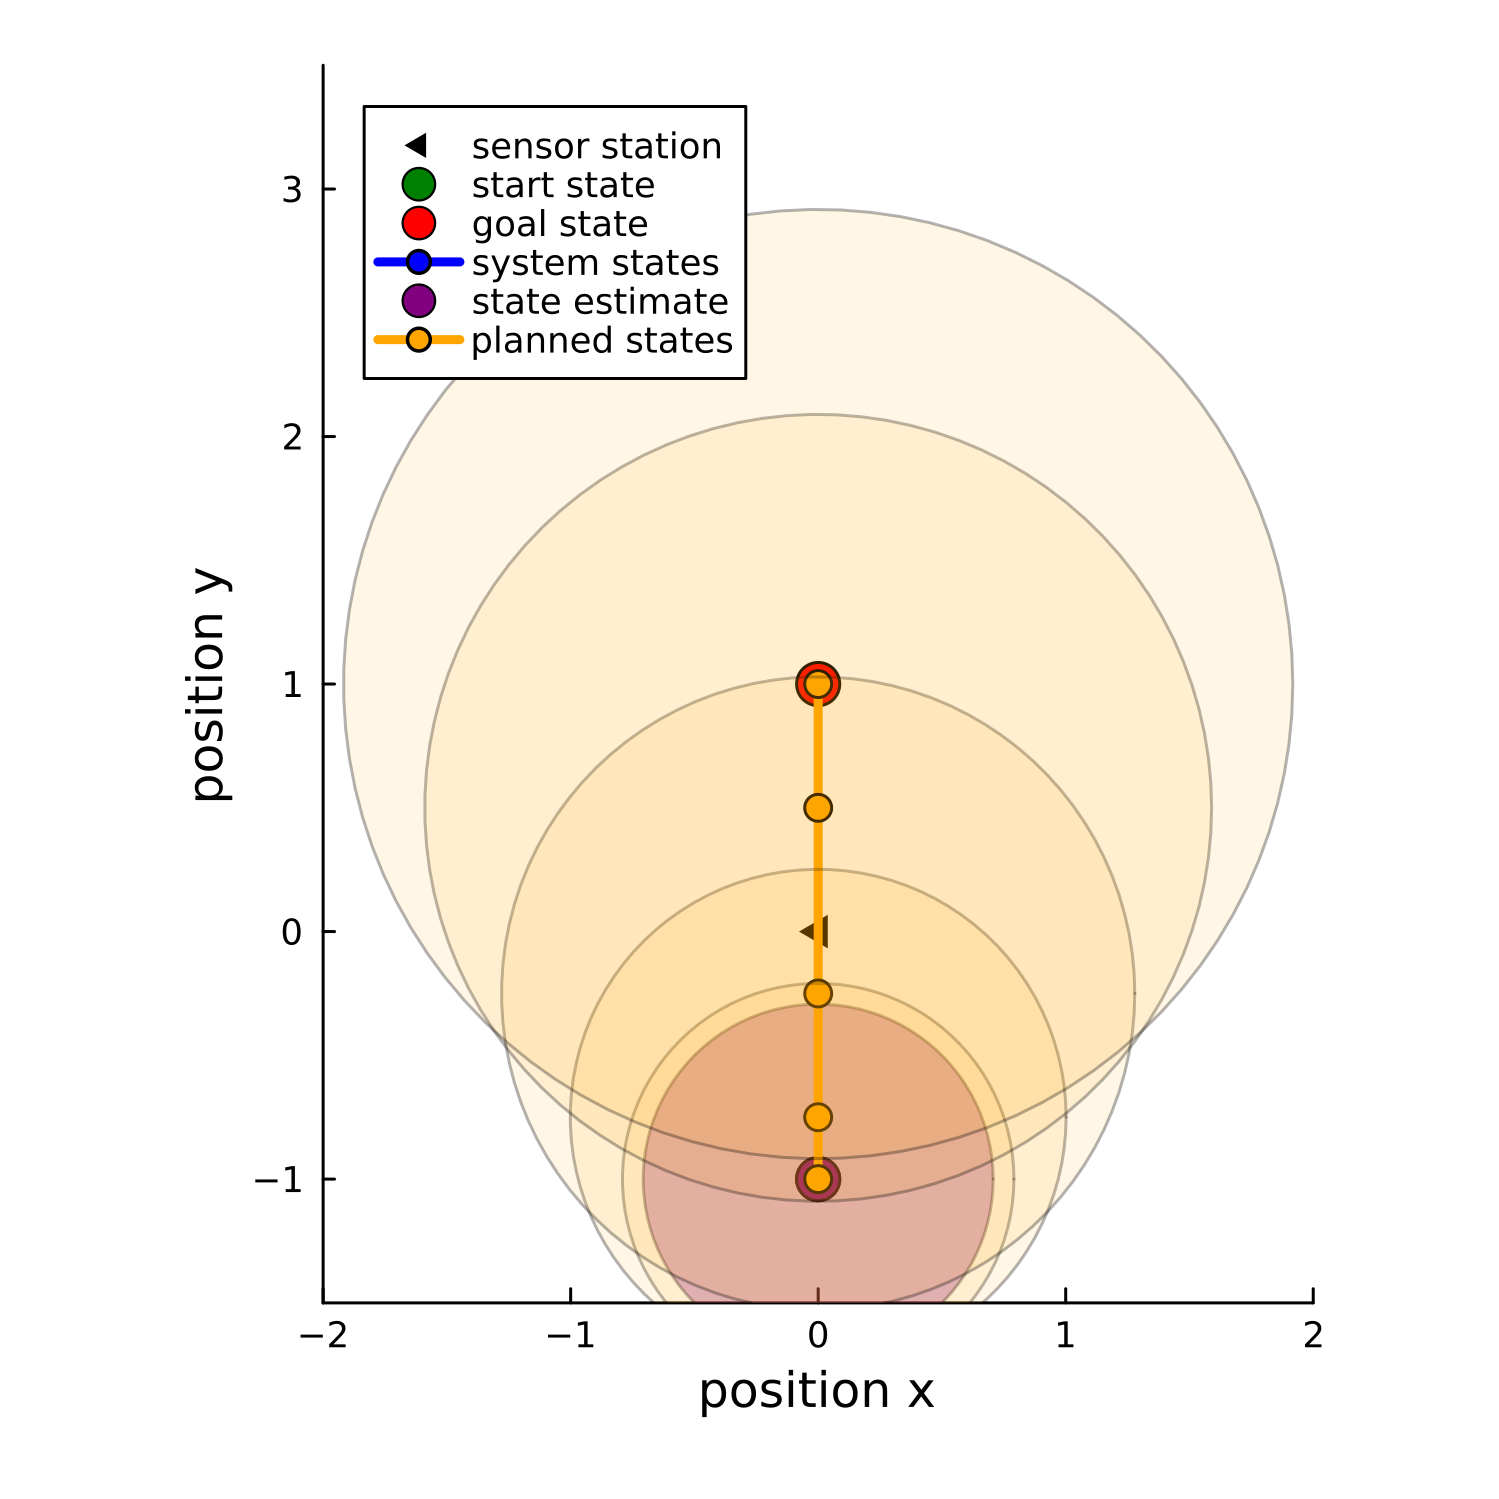

In [309]:
xl = [-2., 2.]
yl = [-1.5, 3.5]

k = 1

p91 = plot(size=(500,500), legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
scatter!([0.0], [0.0], color="black", marker=:ltriangle, label="sensor station", markersize=8)
scatter!([z_0[1]], [z_0[2]], color="green", label="start state", markersize=8)
scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=8)

plot!([z_sim[1,1:k]], [z_sim[2,1:k]], c="blue", marker=".", label="system states", alpha=1., markersize=5)
scatter!([z_est[1][1,k]], [z_est[1][2,k]], c="purple", label="state estimate", alpha=1., markersize=8)
covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=1, fillalpha=0.3)

plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], marker=".", c="orange", markersize=5, label="planned states")
for j in 1:len_horizon
    covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=1, fillalpha=0.1)
end 
plot!(dpi=300)

In [310]:
savefig("figures/cart2polar-mpc-trajectory-k$k.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\figures\\cart2polar-mpc-trajectory-k1.png"

┌ Warning: Skipped marker arg ..
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\args.jl:1148
┌ Warning: Skipped marker arg ..
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\args.jl:1148


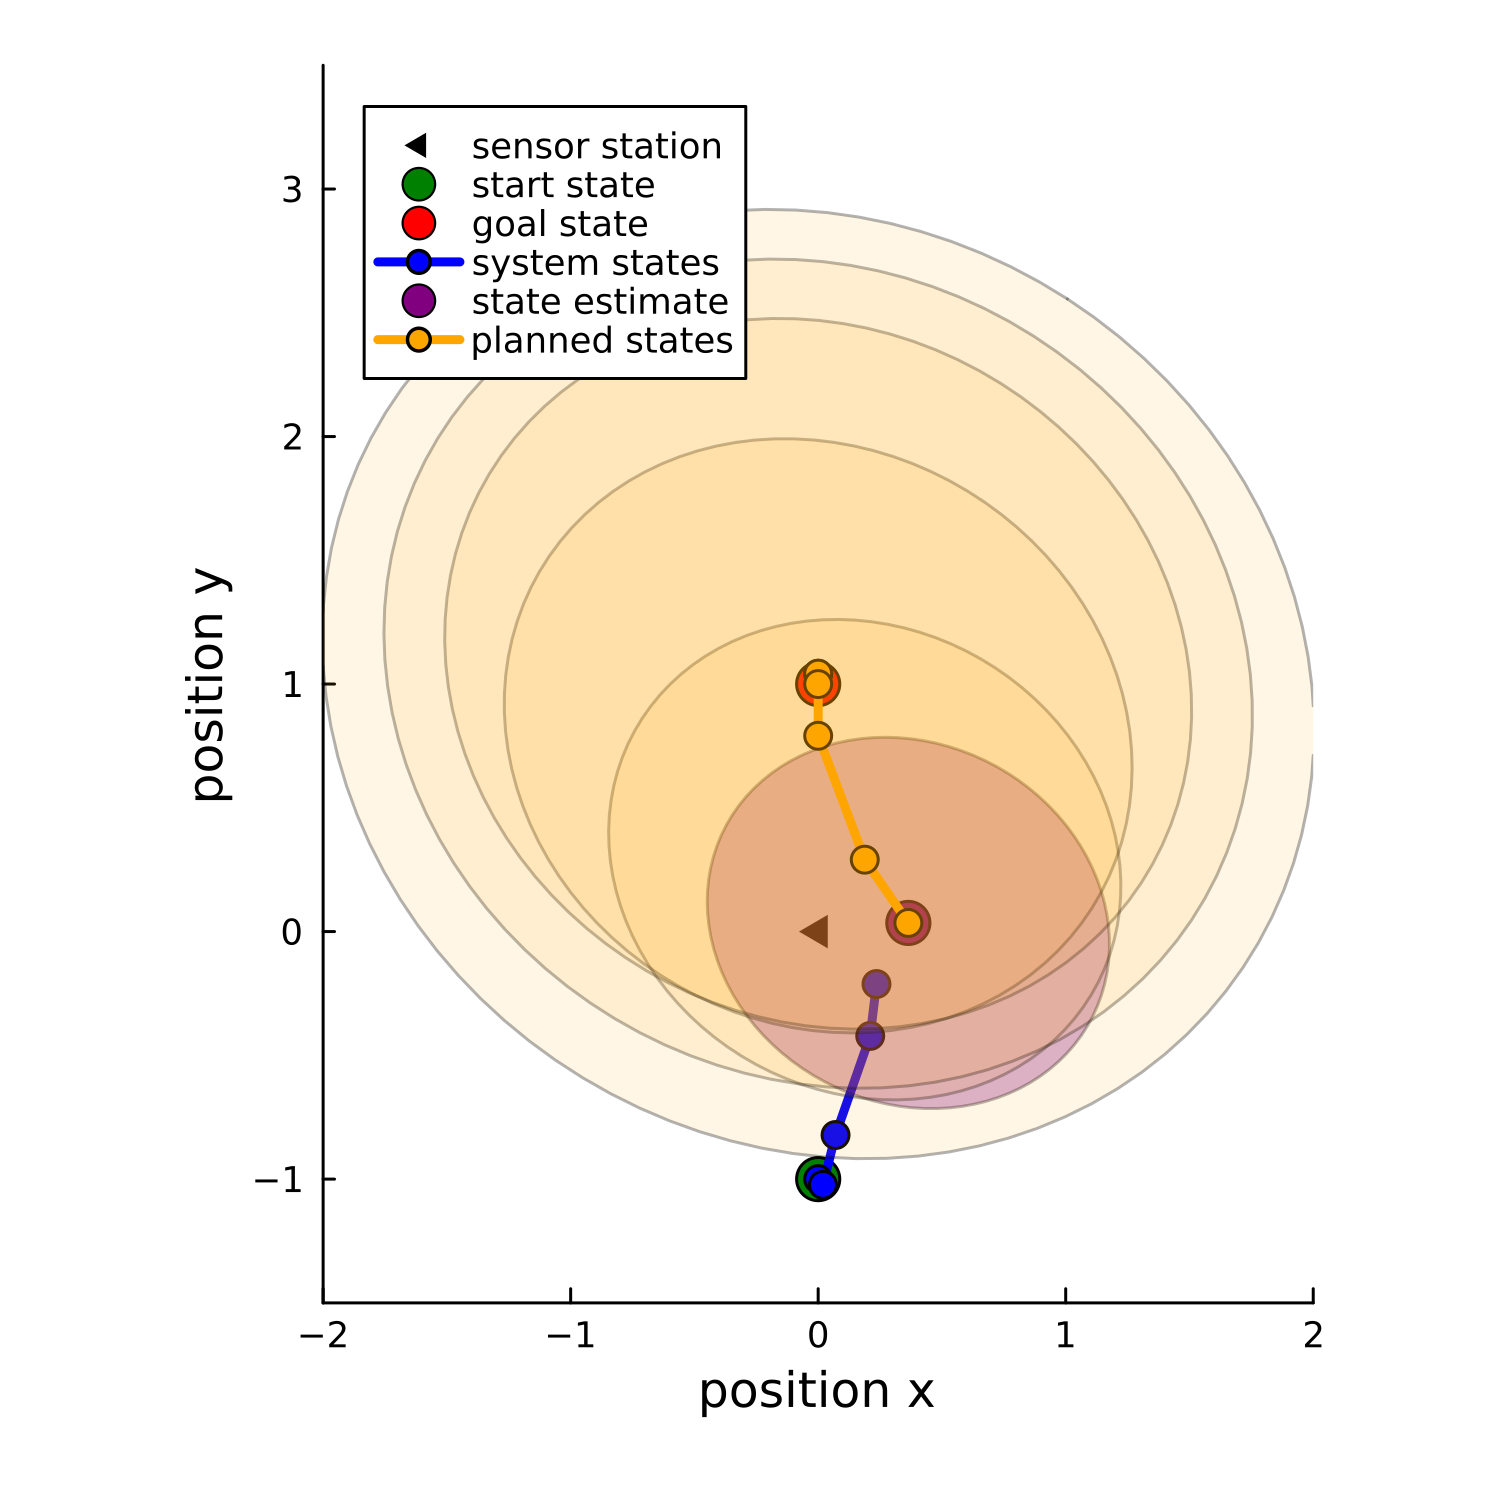

In [317]:
k = 5

p92 = plot(size=(500,500), legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
scatter!([0.0], [0.0], color="black", marker=:ltriangle, label="sensor station", markersize=8)
scatter!([z_0[1]], [z_0[2]], color="green", label="start state", markersize=8)
scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=8)

plot!([z_sim[1,1:k]], [z_sim[2,1:k]], c="blue", marker=".", label="system states", alpha=1., markersize=5)
scatter!([z_est[1][1,k]], [z_est[1][2,k]], c="purple", label="state estimate", alpha=1., markersize=8)
covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=1, fillalpha=0.3)

plot!([z_est[1][1,k]; z_pln[1][k,1,:]], [z_est[1][2,k]; z_pln[1][k,2,:]], marker=".", c="orange", markersize=5, label="planned states")
for j in 1:len_horizon
    covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=1, fillalpha=0.1)
end 
plot!(dpi=300)

In [318]:
savefig("figures/cart2polar-mpc-trajectory-k$k.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\figures\\cart2polar-mpc-trajectory-k5.png"

┌ Warning: Skipped marker arg ..
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\args.jl:1148
┌ Warning: Skipped marker arg ..
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\args.jl:1148


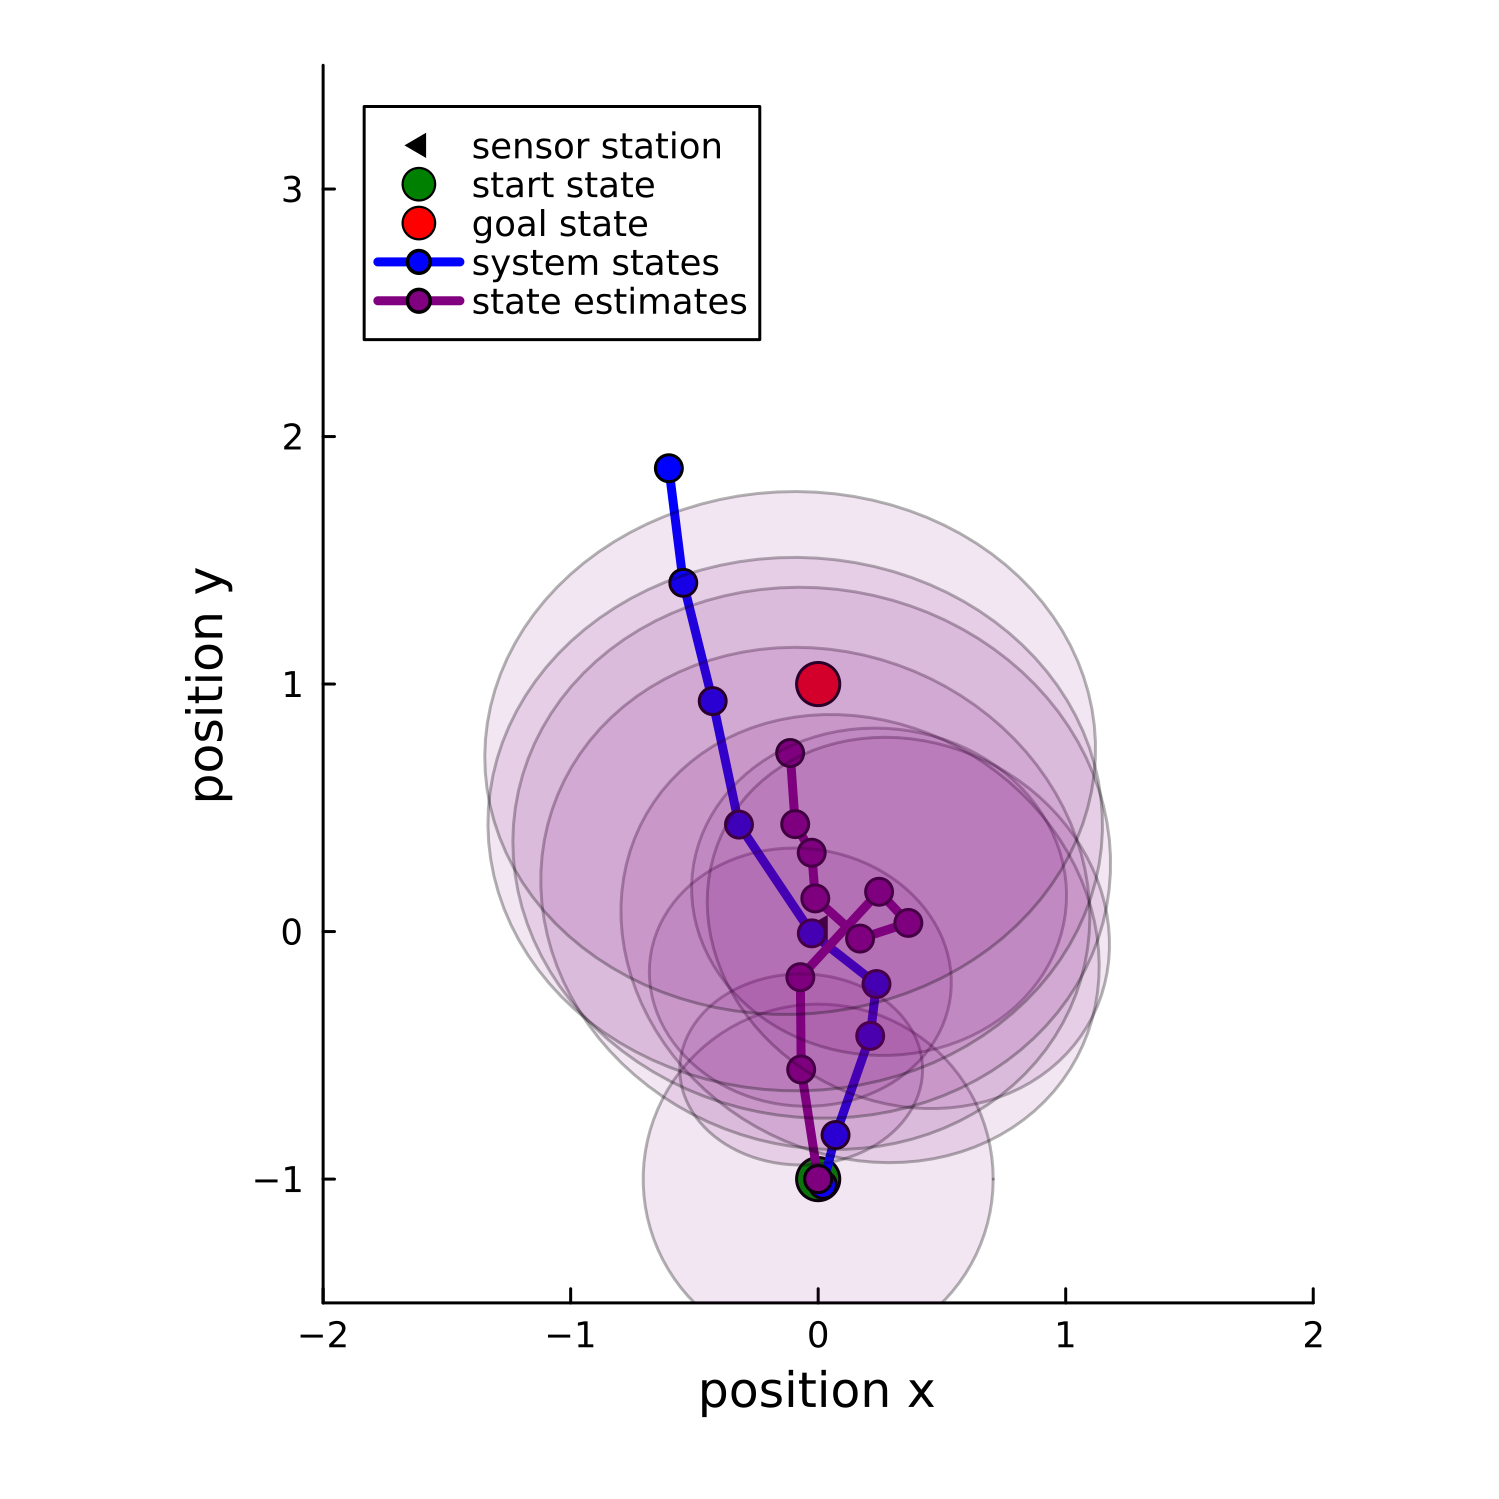

In [321]:
k = len_trial

p93 = plot(size=(500,500), legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
scatter!([0.0], [0.0], color="black", marker=:ltriangle, label="sensor station", markersize=8)
scatter!([z_0[1]], [z_0[2]], color="green", label="start state", markersize=8)
scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=8)

plot!([z_sim[1,1:k]], [z_sim[2,1:k]], c="blue", marker=".", label="system states", alpha=1., markersize=5)

plot!(z_est[1][1,1:k], z_est[1][2,1:k], c="purple", marker=".", label="state estimates", alpha=1., markersize=5)
for j in 1:len_trial
    covellipse!(z_est[1][1:2,j], z_est[2][1:2,1:2,j], n_std=1, color="purple", linewidth=1, fillalpha=0.1)
end
plot!(dpi=300)

In [322]:
savefig("figures/cart2polar-mpc-trajectory-trial.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\figures\\cart2polar-mpc-trajectory-trial.png"